# CLV model

[Customer value in non-contractual business model](https://towardsdatascience.com/whats-a-customer-worth-8daf183f8a4f)

[lifetimes python package](https://github.com/CamDavidsonPilon/lifetimes) for modeling customer lifetime value (CVL).

[CLV in pyspark](http://webdropin.com/wordpress99/customer-lifetime-value-in-pyspark/)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from lifetimes import BetaGeoFitter

from lifetimes.plotting import plot_frequency_recency_matrix

import helper as h

In [20]:
user_data = h.get_merged_data(appName='CVL-model', year='2018').toPandas()
user_data.head()

% of users dropped 58.0832295558323


,login,followers_count,following_count,blog,company,created_at,public_repos_count,public_gists_count,hireable,updated_at,...,GollumEvent_count,IssueCommentEvent_count,IssuesEvent_count,MemberEvent_count,PublicEvent_count,PullRequestEvent_count,PullRequestReviewCommentEvent_count,PushEvent_count,ReleaseEvent_count,WatchEvent_count
0,0loky0,0,1,0,0,2011-05-24 20:15:25+00:00,7.0,0.0,1,2019-01-09 15:03:59+00:00,...,0,0,0,0,0,0,0,32,0,0
1,1xPdd,0,0,0,0,2014-07-11 03:45:56+00:00,0.0,0.0,0,2018-12-16 00:55:16+00:00,...,0,5,2,0,0,0,0,0,0,1
2,2582056905xy,2,6,0,0,2014-04-24 14:51:26+00:00,35.0,0.0,0,2018-10-18 01:47:18+00:00,...,0,0,0,0,0,0,0,0,0,1
3,AJ340,3,6,1,0,2016-04-15 18:12:45+00:00,17.0,0.0,0,2019-01-07 16:25:43+00:00,...,0,0,0,0,0,0,0,4,0,0
4,AaronWB,3,0,1,0,2014-02-11 15:03:04+00:00,25.0,1.0,0,2019-01-20 11:57:00+00:00,...,0,1,3,0,0,0,0,9,1,2


In [21]:
#pd.to_datetime(users['created_at'], errors='coerce')
user_data = h.add_time_columns(user_data, end_date='2018-06-01 23:59:59+00:00')

In [22]:
user_data.head()

,login,followers_count,following_count,blog,company,created_at,public_repos_count,public_gists_count,hireable,updated_at,...,IssuesEvent_count,MemberEvent_count,PublicEvent_count,PullRequestEvent_count,PullRequestReviewCommentEvent_count,PushEvent_count,ReleaseEvent_count,WatchEvent_count,T,recency
0,0loky0,0,1,0,0,2011-05-24 20:15:25,7.0,0.0,1,2019-01-09 15:03:59+00:00,...,0,0,0,0,0,32,0,0,366.0,366.368457
1,1xPdd,0,0,0,0,2014-07-11 03:45:56,0.0,0.0,0,2018-12-16 00:55:16+00:00,...,2,0,0,0,0,0,0,1,203.0,195.511111
2,2582056905xy,2,6,0,0,2014-04-24 14:51:26,35.0,0.0,0,2018-10-18 01:47:18+00:00,...,0,0,0,0,0,0,0,1,214.0,211.956475
3,AJ340,3,6,1,0,2016-04-15 18:12:45,17.0,0.0,0,2019-01-07 16:25:43+00:00,...,0,0,0,0,0,4,0,0,111.0,100.285813
4,AaronWB,3,0,1,0,2014-02-11 15:03:04,25.0,1.0,0,2019-01-20 11:57:00+00:00,...,3,0,0,0,0,9,1,2,224.0,222.789059


### T, recency and frequency

Definitions from [lifetime](https://lifetimes.readthedocs.io/en/latest/Quickstart.html):

`frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

`T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

`recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

### Model CLV

In [35]:
user_data['recency'] = np.floor(user_data.recency)
lifetime_df = user_data[['frequency', 'recency', 'T', 'login']]
lifetime_df = lifetime_df.dropna()

In [36]:
lifetime_df.head()

,frequency,recency,T,login
0,33,366.0,366.0,0loky0
1,8,195.0,203.0,1xPdd
2,1,211.0,214.0,2582056905xy
3,6,100.0,111.0,AJ340
4,25,222.0,224.0,AaronWB


In [37]:
lifetime_df = lifetime_df[(lifetime_df["T"] >= 0)]
lifetime_df = lifetime_df[lifetime_df["recency"] >= 0]

In [38]:
lifetime_df.describe()

,frequency,recency,T
count,80514.000000,80514.000000,80514.000000
mean,26.938445,232.334575,238.706150
std,37.515304,99.699539,98.869448
min,1.000000,0.000000,0.000000
25%,3.000000,149.000000,156.000000
50%,11.000000,218.000000,224.000000
75%,33.000000,298.000000,304.000000
max,199.000000,539.000000,539.000000


In [27]:
# similar API to scikit-learn and lifelines.
lft_df = lifetime_df.sample(n=5000, random_state=0)
bgf = BetaGeoFitter(penalizer_coef=1e-8)
bgf.fit(lft_df['frequency'], lft_df['recency'], lft_df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 0.00, alpha: 4.86, b: 0.93, r: 0.64>


In [28]:
# save the model
bgf.save_model('CLV.pkl')

/home/brian/anaconda3/lib/python3.7/site-packages/lifetimes/fitters/beta_geo_fitter.py:214: RuntimeWarning: overflow encountered in double_scalars
  ((alpha + T) / (alpha + recency)) ** (r + x)


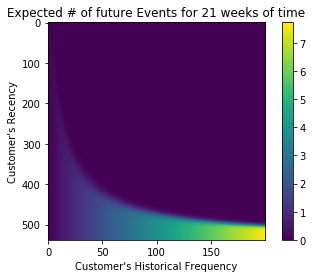

In [29]:
n_weeks=21
plot_frequency_recency_matrix(bgf, T=n_weeks, max_frequency=None, max_recency=None,
                             title='Expected # of future Events for {0} weeks of time'.format(n_weeks))

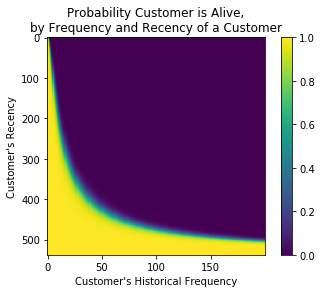

In [30]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

## Expected contributions in the upcoming cycle

In [31]:
lft_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(n_weeks,
                                                                                        lft_df['frequency'], 
                                                                                        lft_df['recency'], 
                                                                                        lft_df['T'])
lft_df.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,login,predicted_purchases
14745,181,121.0,122.0,gitavenue5,30.064903
34188,185,112.0,118.0,melashry,30.962182
78916,185,112.0,115.0,gottsch,32.513517
37514,191,115.0,116.0,tmwarchitecture,33.294711
16369,199,111.0,112.0,jamesbyrne89,35.871730


[[1.         0.39292656]
 [0.39292656 1.        ]]


56.794956813315

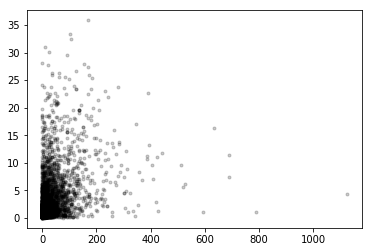

In [32]:
#user_data.dtypes
predict_df = lft_df.merge(user_data, on='login', how='left')
#predict_df = predict_df[predict_df.second_period_event_count < 60]
plt.plot(predict_df.second_period_event_count, predict_df.predicted_purchases, 'k.', alpha=0.2)
#plt.xlim([0, 60])
#plt.ylim([0, 60])

print(np.corrcoef(predict_df.predicted_purchases, predict_df.second_period_event_count))
np.sqrt(np.mean((predict_df.predicted_purchases - predict_df.second_period_event_count) ** 2))

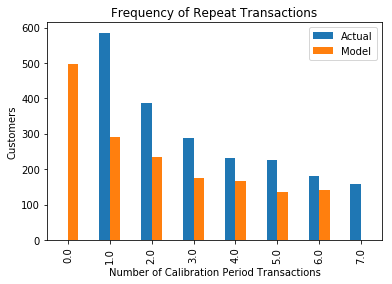

In [33]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

No handles with labels found to put in legend.


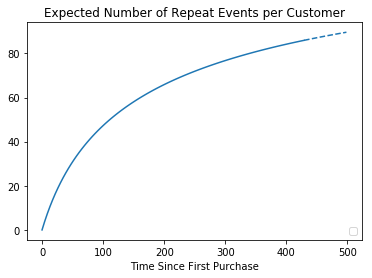

In [23]:
from lifetimes.plotting import plot_expected_repeat_purchases
plot_expected_repeat_purchases(bgf, title='Expected Number of Repeat Events per Customer')
                                   #xlabel='Time Since First Purchase',
                                   #ax=None,
                                   #label=None,
                                   #**kwargs